In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

C:\Users\vikio\AppData\Local\Temp\ipykernel_10648\2836724294.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [25]:
height = 64
width = 128
size = height*width
path = "..\..\datasets\CIC-IDS-2017"
csv_file = path + "\cicids2017_img_serialized_5.csv"

In [3]:
df = pd.read_csv(path+"\CICIDS_converted_data.csv")

In [4]:
df = df.drop_duplicates()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 763416 entries, 0 to 1410250
Columns: 1505 entries, payload_byte_1 to label
dtypes: float64(1), int64(1502), object(2)
memory usage: 8.6+ GB


In [6]:
df.columns

Index(['payload_byte_1', 'payload_byte_2', 'payload_byte_3', 'payload_byte_4',
       'payload_byte_5', 'payload_byte_6', 'payload_byte_7', 'payload_byte_8',
       'payload_byte_9', 'payload_byte_10',
       ...
       'payload_byte_1496', 'payload_byte_1497', 'payload_byte_1498',
       'payload_byte_1499', 'payload_byte_1500', 'ttl', 'total_len',
       'protocol', 't_delta', 'label'],
      dtype='object', length=1505)

In [7]:
df.protocol.unique()

array(['udp', 'tcp'], dtype=object)

In [8]:
df.protocol = df.protocol.apply(lambda x: 1 if x == "tcp" else 0 )

In [9]:
df.protocol.unique()

array([0, 1], dtype=int64)

In [10]:
LABELS = df.label.unique()
LABELS

array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
       'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'Heartbleed',
       'Infiltration', 'PortScan', 'SSH-Patator',
       'Web Attack – Brute Force', 'Web Attack – Sql Injection',
       'Web Attack – XSS'], dtype=object)

In [11]:
len(df.label.unique())

15

In [12]:
df.label.value_counts() / len(df)

label
BENIGN                        0.414680
DoS Hulk                      0.181884
DoS GoldenEye                 0.139702
DoS slowloris                 0.080010
DoS Slowhttptest              0.077863
SSH-Patator                   0.049592
Infiltration                  0.022054
FTP-Patator                   0.016920
Web Attack – Brute Force      0.009302
Bot                           0.002675
Web Attack – XSS              0.002379
Heartbleed                    0.001606
DDoS                          0.001078
PortScan                      0.000242
Web Attack – Sql Injection    0.000014
Name: count, dtype: float64

In [13]:
df = pd.get_dummies(df, columns=['label'])

In [14]:
df = df.to_numpy()
df.shape

(763416, 1519)

In [15]:
df.dtype, df.nbytes

(dtype('O'), 9277031232)

In [18]:
# normalize payload, ttl, total_len
for col_index in range(df.shape[1]-17):
    column = df[:, col_index]
    column_normalized = (column - np.min(column)) / (np.max(column) - np.min(column))
    df[:, col_index] = column_normalized

In [16]:
# inspect t_delta
print(np.min(df[:, -16]), np.max(df[:, -16]))

-1.8e-05 58.352796


In [17]:
# normalize t_delta
column = df[:, -16]
column_normalized = (column - np.min(column)) / (np.max(column) - np.min(column))
df[:, -16] = column_normalized

In [19]:
df = df.astype(np.float16)
df.dtype, df.nbytes

(dtype('float16'), 2319257808)

In [20]:
np.random.shuffle(df)
df.shape, df[0, -15:]

((763416, 1519),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float16))

In [22]:
def translate_encoded_label(encoded_label):
        return LABELS[list(encoded_label).index(1)]
    
translate_encoded_label(df[0, -15:])

'DoS GoldenEye'

(5, 1504) BENIGN
(7520,)
BENIGN
(8192,)
(64, 128)


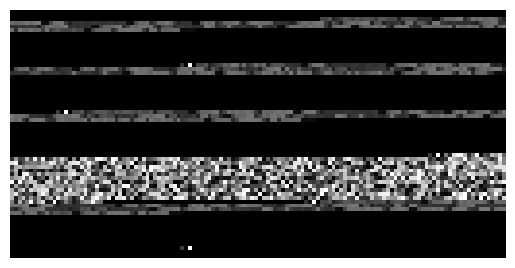

DONE


In [23]:
def convert_dataset_to_grayscale_image(arr):
    for idx in range(len(arr) - 5):
        batch = arr[idx: idx + 5, :-15]
        label = translate_encoded_label(arr[idx + 5, -15:])
        print(batch.shape, label)
        data = np.concatenate(batch)
        print(data.shape)
        print(label)
        
        data = np.pad(data, pad_width=int((size-len(data))/2), constant_values=0)
        print(data.shape)
        data = data.reshape(height, width).astype('float64')
        print(data.shape)
        
        plt.imshow(data, cmap='gray')
        plt.axis('off')  # Remove axes
        plt.show()
        
        break
    print("DONE")
        
convert_dataset_to_grayscale_image(df)

(5, 1504) BENIGN
(7520,)
BENIGN
(64, 128)
(64, 128)
(64, 128)
(64, 128, 3)


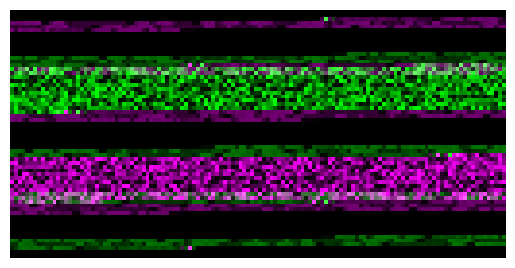

DONE


In [24]:
def convert_dataset_to_rgb_image(arr):
    for idx in range(len(arr) - 5):
        batch = arr[idx: idx + 5, :-15]
        label = translate_encoded_label(arr[idx + 5, -15:])
        print(batch.shape, label)
        data = np.concatenate(batch)
        print(data.shape)
        print(label)
        
        data = np.pad(data, pad_width=int((size-len(data))/2), constant_values=0)
        data = data.reshape(height, width)
        
        channel_1 = data.astype('float64')
        print(channel_1.shape)
        channel_2 = np.rot90(channel_1, k=2).reshape(height, width)
        print(channel_2.shape)
        channel_3 = np.rot90(channel_2, k=2).reshape(height, width)
        print(channel_3.shape)
        img = np.stack((channel_1, channel_2, channel_3)).transpose((1, 2, 0))
        print(img.shape)
        
        plt.imshow(img)
        plt.axis('off')  # Remove axes
        plt.show()
        
        break
    print("DONE")
        
convert_dataset_to_rgb_image(df)

In [26]:
with open(csv_file, 'w') as f:
    np.savetxt(f, [np.array(["file_name", "label"])], delimiter=',', fmt='%s')

def convert_dataset_to_image(arr):
    with open(csv_file, 'a') as f:
        for idx in range(len(arr) - 5):
            batch = arr[idx: idx + 5, :-15]
            label = translate_encoded_label(arr[idx + 5, -15:])
            data = np.concatenate(batch)
            if idx % 10_000 == 0:
                    print(idx, label)
            
            data = np.pad(data, pad_width=int((size-len(data))/2), constant_values=0)
            data = data.reshape(height, width)
            
            channel_1 = data.astype('float64')
            channel_2 = np.rot90(channel_1, k=2).reshape(height, width)
            channel_3 = np.rot90(channel_2, k=2).reshape(height, width)
            img = np.stack((channel_1, channel_2, channel_3)).transpose((1, 2, 0))
            
            file_name = f"cic_ids_2017_{idx}.png"
            cv2.imwrite(path+"\image_serialized_5\\"+file_name, img*255)
            
            log = np.array([file_name, label])
            np.savetxt(f, [log], delimiter=',', fmt='%s')
    print("DONE")
        
convert_dataset_to_image(df)

0 BENIGN
10000 BENIGN
20000 SSH-Patator
30000 SSH-Patator
40000 BENIGN
50000 BENIGN
60000 FTP-Patator
70000 DoS Slowhttptest
80000 SSH-Patator
90000 BENIGN
100000 DoS Hulk
110000 BENIGN
120000 DoS Hulk
130000 BENIGN
140000 SSH-Patator
150000 BENIGN
160000 BENIGN
170000 DoS slowloris
180000 DoS Slowhttptest
190000 DoS slowloris
200000 DoS Slowhttptest
210000 BENIGN
220000 DoS GoldenEye
230000 DoS GoldenEye
240000 DoS slowloris
250000 BENIGN
260000 DoS Hulk
270000 Infiltration
280000 DoS slowloris
290000 DoS Hulk
300000 BENIGN
310000 BENIGN
320000 BENIGN
330000 BENIGN
340000 DoS GoldenEye
350000 DoS GoldenEye
360000 DoS Hulk
370000 DoS slowloris
380000 BENIGN
390000 BENIGN
400000 DoS Hulk
410000 FTP-Patator
420000 SSH-Patator
430000 BENIGN
440000 DoS GoldenEye
450000 BENIGN
460000 DoS Hulk
470000 DoS GoldenEye
480000 BENIGN
490000 DoS Hulk
500000 BENIGN
510000 DoS GoldenEye
520000 DoS GoldenEye
530000 DoS Hulk
540000 DoS Hulk
550000 BENIGN
560000 DoS Hulk
570000 DoS slowloris
580000 BENI